# General setup for all models

In [1]:
import models as models
import model_params
import numpy as np
import copy
import matplotlib.pyplot as plt
import importlib
from scipy import signal as sig

## Defining functions

In [9]:
def plot_2dtrajectories(X, model_params):
    targ_coords = model_params.target_coordinates # final target coordinates common for both agents
    vp1_coords = model_params.viapoint1_coordinates # via point coordinates for agent 1
    vp2_coords = model_params.viapoint2_coordinates # via point coordinates of agent 2

    fig, ax = plt.subplots()
    ax.axis('equal')
    ax.set_xlim(-0.1, 0.1)
    ax.set_ylim(-0.02, 0.17)
    ax.set_xlabel('X Coordinate (m)')
    ax.set_ylabel('Y Coordinate (m)')
    ax.scatter(0, 0, s=30, color='k', zorder=0)
    ax.scatter(targ_coords[0], targ_coords[1], s=30, color='k', zorder=0)

    ax.plot(X[0, :], X[1, :], 'darkorange', label='Agent 1')
    ax.scatter(vp1_coords[0], vp1_coords[1], s=30, color='darkorange', zorder=0)

    ax.plot(X[8, :], X[9, :], 'darkorchid', label='Agent 2')
    ax.scatter(vp2_coords[0], vp2_coords[1], s=30, color='darkorchid', zorder=0)

    ax.legend()

    return fig, ax

def plot_stateevolution(X, U1, U2):
    fig, ax = plt.subplots(4, 1, figsize=(6, 10))
    ax[0].plot(X[0, :], color='darkorange')
    ax[0].plot(X[8, :], color='darkorchid')
    ax[0].set_ylabel('x position')
    ax[1].plot(X[1, :], color='darkorange')
    ax[1].plot(X[9, :], color='darkorchid')
    ax[1].set_ylabel('y position')
    ax[2].plot(U1[0, :], color='darkorange')
    ax[2].plot(U2[0, :], color='darkorchid')
    ax[2].set_ylim((-np.max(np.abs(u2[0, :])), np.max(np.abs(u1[0, :]))))
    ax[2].set_ylabel('x control') 
    ax[3].plot(U1[1, :], color='darkorange')
    ax[3].plot(U2[1, :], color='darkorchid')
    ax[3].set_ylabel('y control')

    return fig, ax

## Setting general model and task parameters

In [13]:
model_params.params['r'] = 0.00001 # control cost scaling
model_params.params['c'] = 20 # velocity damping characteristics of the agent
model_params.params['k_h'] = 40 # spring constant of spring connecting the two agents

N = model_params.params['N'] # total number of finite horizon steps

targ_coords = model_params.target_coordinates # final target coordinates common for both agents
vp1_coords = model_params.viapoint1_coordinates # via point coordinates for agent 1
vp2_coords = model_params.viapoint2_coordinates # via point coordinates of agent 2

# DIfferential Game Theoretic Model

## Setting inital conditions

In [41]:
shared_cost = (False, False) # whether agent 1 and agent 2 consider partner cost? format: (agent1_shares, agent2_shares)
GT_Model = models.TwoHands_Model_GameTheoretic_Base(params=model_params.params, 
                                            vp_cross_timestep=model_params.viapoint_crossing_timestep, shared_cost=shared_cost)

x0 = np.zeros(GT_Model.A.shape[0]) # initial state of the combined state space system of the two agents
x0[[-6, -5, -4, -3, -2, -1]] = [targ_coords[0], targ_coords[1], vp1_coords[0], vp1_coords[1], 
                                vp2_coords[0], vp2_coords[1]] # see model class for description of state vector elements

GT_Model.compute_controlfeedbackgains() # using differential game theory to compute the control feedback gains

## Run simulation


In [42]:
u1 = np.zeros((GT_Model.control_len, N)) # initializing control vector for agent 1
u2 = np.zeros((GT_Model.control_len, N)) # initializing control vector for agent 2
x = np.zeros((GT_Model.state_len, N + 1)) # initializing state vector for the state space system
x[:, 0] = x0.copy() # setting first column to initial state of the system

for step in range(N):
    # computing the control action for each agent
    u1[:, [step]] = - GT_Model.L1[step, :, :] @ x[:, [step]] - GT_Model.l1[step, :, :]
    u2[:, [step]] = - GT_Model.L2[step, :, :] @ x[:, [step]] - GT_Model.l2[step, :, :]

    # forward propagating the states
    x[:, step + 1] = GT_Model.A @ x[:, step] + GT_Model.B1 @ u1[:, step] + GT_Model.B2 @ u2[:, step]  +\
                        np.random.normal(0, model_params.process_noise)

# computing the costs incurred by each agent
trajec_cost1, trajec_cost2 = GT_Model.compute_trajectory_cost(x=x, u1=u1, u2=u2)
print(f'Trajectory costs are {trajec_cost1} and {trajec_cost2}')

Trajectory costs are 3.2702563558630724e-05 and 3.92942661415012e-05


## Plot trajectories of the two agents

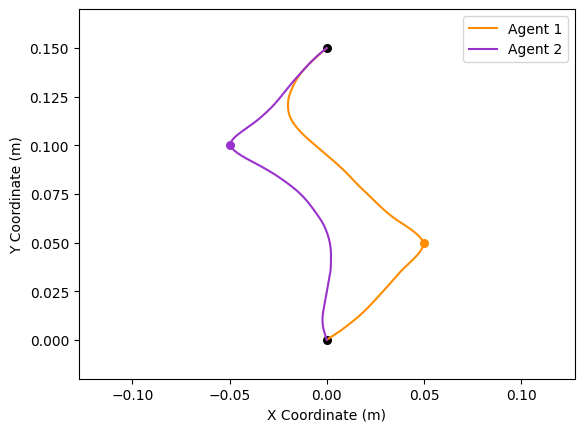

In [43]:
fig, ax = plot_2dtrajectories(x, model_params=model_params)
fig.savefig('UnsharedCosts.png', transparent=False, dpi=300)

## Plotting the states

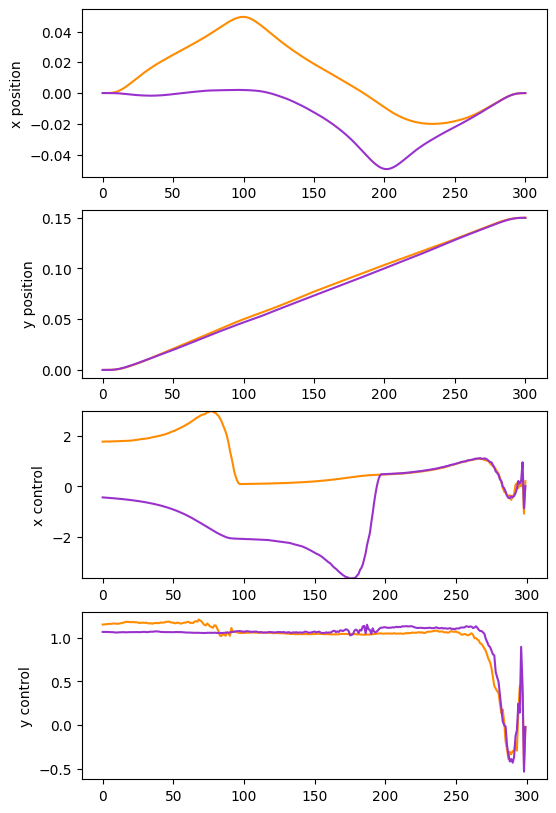

In [27]:
fig, ax = plot_stateevolution(x, u1, u2)

# Single LQR model

## Setting inital conditions for simulation

In [17]:
P_Model = models.TwoHands_Model(params=model_params.params, 
                            vp_cross_timestep=model_params.viapoint_crossing_timestep)

targ_coords = model_params.target_coordinates
vp1_coords = model_params.viapoint1_coordinates
vp2_coords = model_params.viapoint2_coordinates

x0 = np.zeros(P_Model.A.shape[0]) 
x0[[-6, -5, -4, -3, -2, -1]] = [targ_coords[0], targ_coords[1], vp1_coords[0], vp1_coords[1], 
                                vp2_coords[0], vp2_coords[1]]

P_Model.compute_controlfeedbackgains()

## Run simulation

In [44]:
u = np.zeros((P_Model.control_len, N))
x = np.zeros((P_Model.state_len, N + 1))
x[:, 0] = x0.copy()

x_est = x.copy()

for step in range(N):
    u[:, step] = - P_Model.L[step, :, :] @ x_est[:, step]
       
    x[:, step + 1] = P_Model.A @ x[:, step] + P_Model.B @ u[:, step] + np.random.normal(0, model_params.process_noise)

    x_est[:, step + 1] = P_Model.estimate_state(x_true_next=x[:, step + 1], x_est_curr=x_est[:, step], u_curr=u[:, step])

trajec_cost = P_Model.compute_trajectory_cost(x=x, u=u)
print(f'Trajectory cost per hand is {trajec_cost / 2}')

Trajectory cost per hand is 0.00010682784349227776


## Plotting 2d trajectories of the two hands

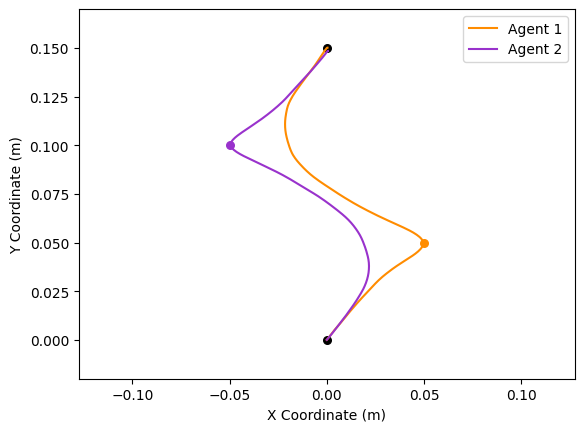

In [45]:
fig, ax = plot_2dtrajectories(x, model_params=model_params)
fig.savefig('SingleLQR.png', dpi=300)

## Plotting states

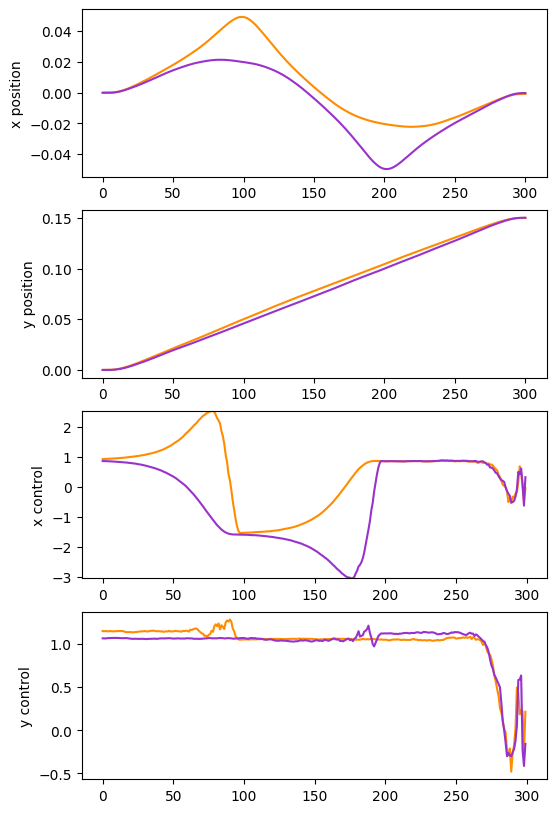

In [20]:
fig, ax = plot_stateevolution(x, u1, u2)